# K Nearest Neighbor
#### Aeon Williams
#### CS398F2020

In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from operator import itemgetter # sort list of tuples
from sklearn.model_selection import train_test_split # splitting the dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore') # mpl produces warnings about it's own code, doesn't affect what I'm doing at all

## KNN Algorithm (vanilla & weighted)
- dependent feature must be right most column

### Euclidean Distance
<img src="./images/dist.PNG" width="200" align='left'/>

In [2]:
# Calculate distance between two vectors (rows of data from a dataframe)
# 0 = most similar (identical)
def euclidean_distance(v1, v2):
    # Iterate through each column of both vectors, adding to distance
    distance = 0
    for i in range(len(v1)-1):
        distance += (v1[i] - v2[i])**2
    return np.sqrt(distance)

### Predict Class Value

In [3]:
# Predict the class value for the given vec, based on the training set given
def get_prediction(train_ls, test_row, k=3, d_weighted=False):
    # Find k number of nearest neighbors
    distances = [(row, (euclidean_distance(row, test_row))) for row in train_ls] # list of tuples [row, distance from row to vec]
    distances.sort(key=itemgetter(1)) # sort from smallest to largest (smallest = closest)

    # Vanilla KNN
    if d_weighted == False:
        neighbors = [distances[i][0] for i in range(k)] # grab first k items from list
        values = [row[-1] for row in neighbors]
        # Find most represented class as the predicted value
        return max(set(values), key=values.count)
    # Distance Weighted KNN
    else:
        distances = distances[:k]
        possible_values = np.unique([row[-1] for row in train_ls]) # values that the prediction can be
        neighbors = [(row[1], row[0][-1]) for row in distances] # list of tuples [distance, class value]
        wt0, wt1 = 0, 0
        for n in neighbors: # where n[0] is the euclidean distance and n[1] is the class value 
            if n[1] == possible_values[0] and n[0] != 0:
                wt0 += (1 / n[0])
            if n[1] == possible_values[1] and n[0] != 0:
                wt1 += (1 / n[0])
        return possible_values[0] if wt0>wt1 else possible_values[1]

### Analysis Tools & Helper Functions

In [4]:
# Based on lists of the actual values and predicted values, evaluate how closely they match
def accuracy_metric(actual, predicted):
    matching_value_count = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            matching_value_count += 1
    return matching_value_count / float(len(actual)) * 100
        
# Takes a dataframe, splits into train and test, and produces the average accuracy of the model 
# (increased # of runs = better indicator of true accuracy)
def evaluate_model(df, k=3, runs=1, weighted=False):
    if k == 0:
        return
    accuracies = list()
    for i in range(runs):
        df_list = df.iloc[0:,:].values.tolist()
        train, test = train_test_split(df_list, test_size=.4, train_size=.6)
        actual = [row[-1] for row in test]
        for row in test:
            row[-1] = None
        pred = [get_prediction(train, row, k, weighted) for row in test]
        accuracy = accuracy_metric(actual, pred)
        accuracies.append(accuracy)
    print("Average accuracy is " + str(round(sum(accuracies)/float(len(accuracies)), 2)) + "%", " with k =", k, " ran", runs, "time(s) and Weighted Distance =", weighted)

# Takes a train and test/validation set, and produces the average accuracy of the model as text output or return value 
# (increased # of runs = better indicator of true accuracy)
def evaluate_model_tt(train, other, k=3, runs=1, weighted=False, out=False):
    if k == 0:
        return
    accuracies = list()
    for i in range(runs):
        train_ls = train.iloc[0:,:].values.tolist()
        other_ls = other.iloc[0:,:].values.tolist()
        actual = [row[-1] for row in other_ls]
        for row in other_ls:
            row[-1] = None
        pred = [get_prediction(train_ls, row, k, weighted) for row in other_ls]
        accuracy = accuracy_metric(actual, pred)
        accuracies.append(accuracy)
    avg_accuracy = str(round(sum(accuracies)/float(len(accuracies)), 2))
    if out:
        print("Average accuracy is " + avg_accuracy + "%", " with k =", k, " ran", runs, "time(s) and Weighted Distance =", weighted)
        return
    else:
        return avg_accuracy

### Data Adjustments

In [5]:
# Normalizes a dataframe from 0 to given range
# preserve_cols are the columns you don't want normalized. Dependent feature should be listed last.
def normalize(df, range_=1, preserve_cols=[]):
    df_norm = df.copy()
    for col in preserve_cols:
        col=str(col)
        df_norm.pop(col)
    df_norm = ((df_norm-df_norm.min()) / (df_norm.max()-df_norm.min())) * range_
    for col in preserve_cols:
        col=str(col)
        df_norm[col] = df[col]
    return df_norm

---

## Model Testing/Overfit Evaluation

In [6]:
def test():
    df = pd.read_csv("./data/Iris.csv")
    normalize(df, 1, ['Species'])
    evaluate_model(df, 5, 50)
    evaluate_model(df, 10, 50)
    evaluate_model(df, 15, 50)
    evaluate_model(df, 5, 50, True)
    evaluate_model(df, 10, 50, True)
    evaluate_model(df, 15, 50, True)
test()

Average accuracy is 98.73%  with k = 5  ran 50 time(s) and Weighted Distance = False
Average accuracy is 97.53%  with k = 10  ran 50 time(s) and Weighted Distance = False
Average accuracy is 97.73%  with k = 15  ran 50 time(s) and Weighted Distance = False
Average accuracy is 65.93%  with k = 5  ran 50 time(s) and Weighted Distance = True
Average accuracy is 65.43%  with k = 10  ran 50 time(s) and Weighted Distance = True
Average accuracy is 66.8%  with k = 15  ran 50 time(s) and Weighted Distance = True


## Data Loading & Cleaning

In [7]:
pred_col = 'diagnosis'
# Load data
df = pd.read_csv("./data/Breast_Cancer.csv")
og_shape = df.shape

# Move independent variable to end
ind_col = df.pop(pred_col)
df.insert(len(df.columns), pred_col, ind_col)

# Fill missing values with mean of column
df.fillna(df.mean(), inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Map diagnosis string to int
diag_map = {'M':0, 'B':1}
df = df.applymap(lambda s: diag_map.get(s) if s in diag_map else s)

print("Number of rows removed:", og_shape[0]-df.shape[0], "\n")
print(df.info())
display(df.sample(3))

Number of rows removed: 0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
conca

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
324,89511501,12.20,15.21,78.01,457.9,0.08673,0.06545,0.01994,0.01692,0.1638,...,21.38,91.11,583.1,0.1256,0.1928,0.11670,0.05556,0.2661,0.07961,1
386,902975,12.21,14.09,78.78,462.0,0.08108,0.07823,0.06839,0.02534,0.1646,...,19.29,87.65,529.9,0.1026,0.2431,0.30760,0.09140,0.2677,0.08824,1
222,8812844,10.18,17.53,65.12,313.1,0.10610,0.08502,0.01768,0.01915,0.1910,...,22.84,71.94,375.6,0.1406,0.1440,0.06572,0.05575,0.3055,0.08797,1


### Normalize the Data

In [8]:
display(df.head(2))
df_norm = normalize(df)
display(df_norm.head(2))

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.000915,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.000915,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0


## Analyze Data

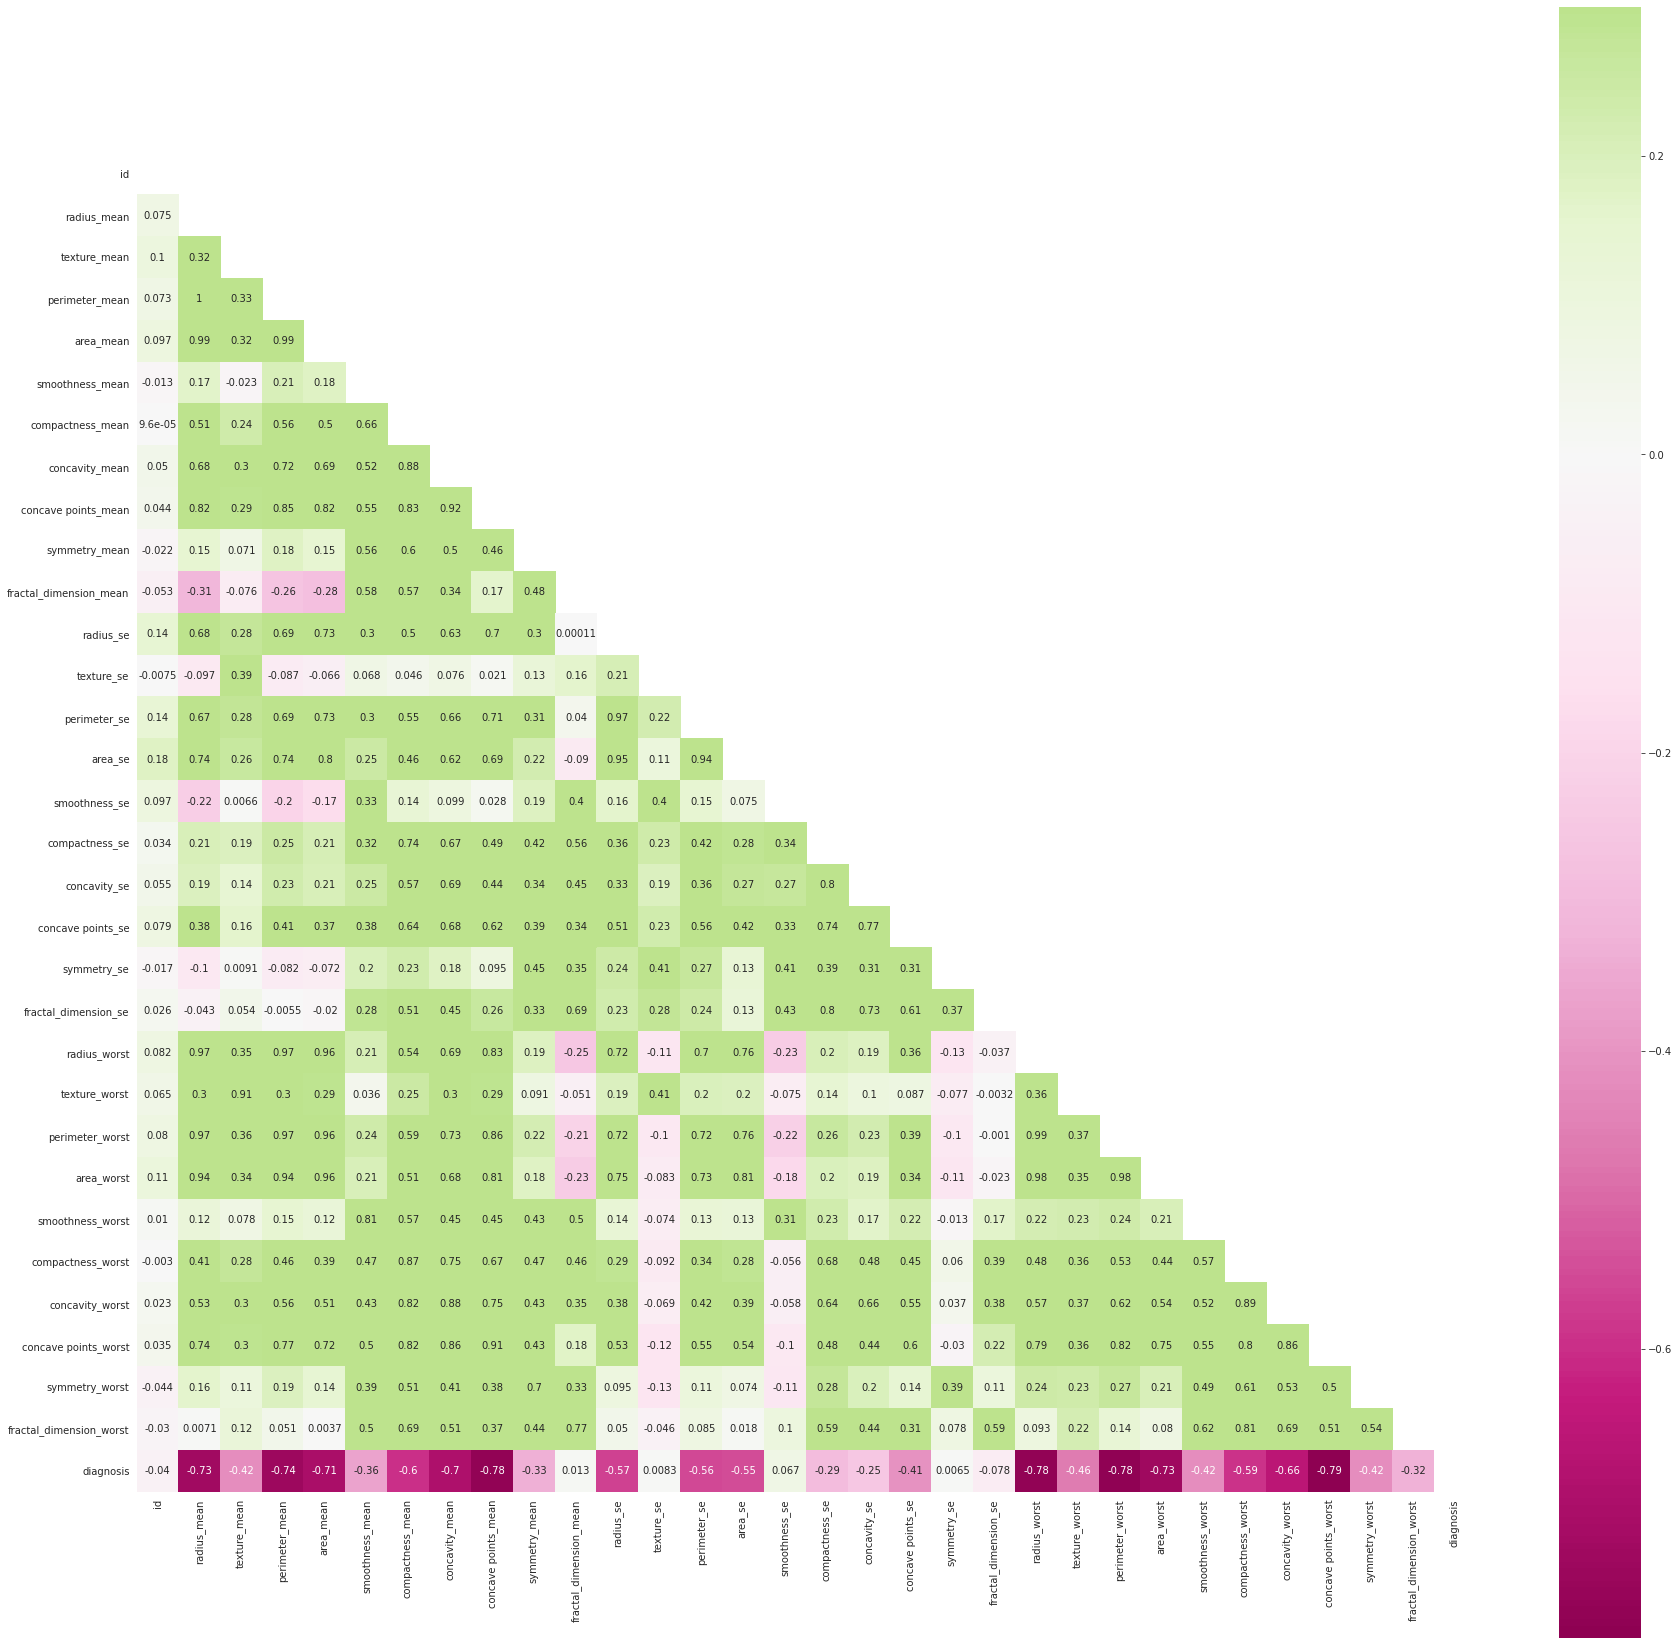

In [9]:
def plot_heatmap(df):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(30, 30))
        ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="PiYG", annot=True, center=0)

plot_heatmap(df_norm)

#### Correlation definitions:
- High:        ± 0.7-0.9
- Moderate:    ± 0.5-0.7
- Low:         ± 0.3-0.5
- Little/None: ± 0.3-0

#### Correlation of dependent feature (diagnosis):
- High: radius_mean, perimeter_mean, area_mean, concavity_mean, concavepoints_mean, radius_worst, perimeter_worst, area_worst, concavepoints_worst
- Moderate: compactness_mean, radius_se, perimeter_se, area_se, compactness_worst, concavity_worst
- Low: texture_mean, smoothness_mean, symmetry_mean, concavepoints_se, texture_worst, smoothness_worst, symmetry_worst, fractal_dimension_worst
- None: fractal_dimension_mean, texture_se, smoothness_se, symmetry_se, fractal_dimension_se, id

Note: All features except for fractal_dimension_mean, texture_se, smoothness_se, and symmetry_se have a negative correlation

#### High correlation feature pairs of independent features with low to no correlation to the depedent feature:
- concavepoints_worst and: radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concavepoints_mean, radius_worst, perimeter_worst, area_worst, compactness_worst, concavity_worst
- concavity_worst and: compactness_mean, concavity_mean, concavepoints_mean, compactness_worst
- compactness_worst and: compactness_mean
- area_worst and : radius_mean, perimeter_mean, area_mean, concavepoints_mean, area_se, radius_se, perimeter_se, radius_worst, perimeter_worst
- perimeter_worst and: radius_mean, perimeter_mean, area_mean, concavity_mean, concavepoints_mean, radius_se, perimeter_se, area_se, radius_worst
- radius_worst and: radius_mean, perimeter_mean, area_mean, perimeter_se
- concavepoints_se and: compactness_se, concavity_se
- area_se and: perimeter_se, radius_se
- perimeter_se and: area_mean, concavepoints_mean, radius_se
- radius_se and: concavepoints_mean
- concavepoints_mean and: radius_mean, perimeter_mean, compactness_mean, concavity_mean
- area_mean and: radius_mean, perimeter_mean

#### Good candidates for features to use in the model based on the above information:
- concave points_worst
- radius_worst
- compactness_worst
- perimeter_mean
- concavity_mean
- compactness_mean
- radius_se

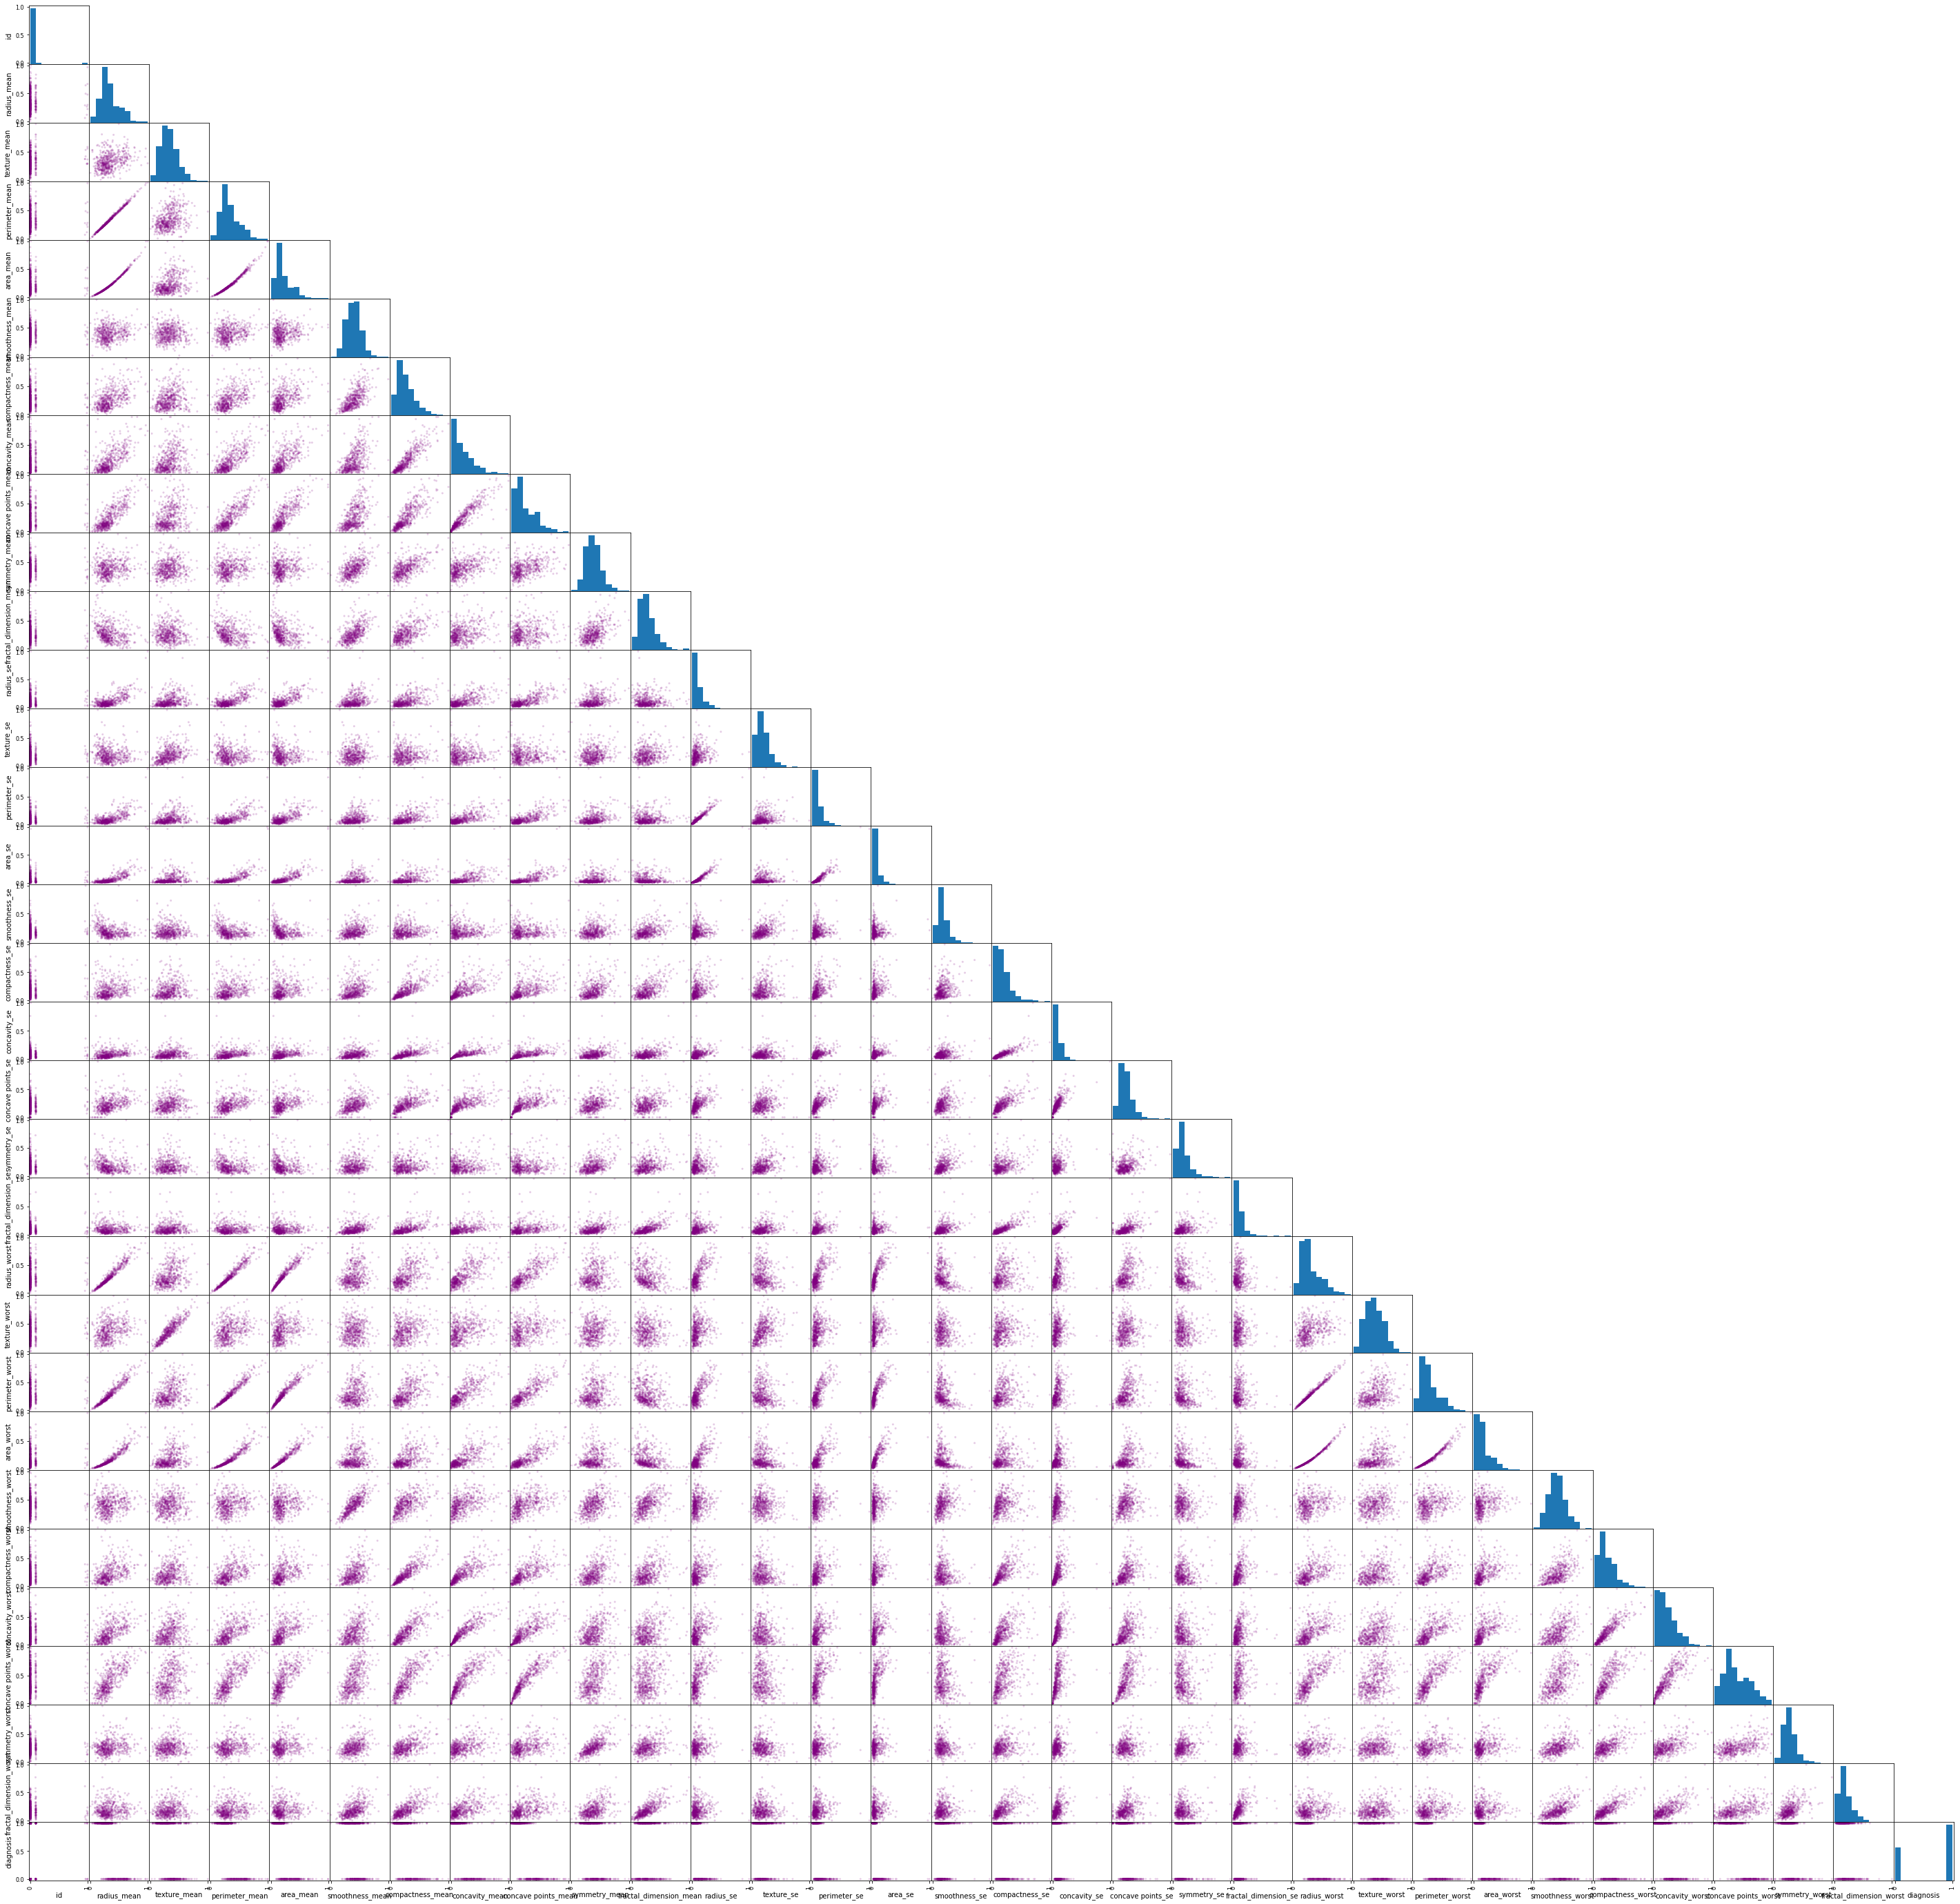

In [10]:
def plot_scatter(df):
    axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(50,50), c="purple")

    for i in range(np.shape(axes)[0]):
        for j in range(np.shape(axes)[1]):
            if i < j:
                axes[i,j].set_visible(False)
    plt.show()
    
plot_scatter(df_norm)

## Parameter Optimization Testing: k & train/test split

### Split Data into train, validation, test

In [22]:
df_cut = df_norm[['concave points_worst', 'radius_worst', 'compactness_worst', 'perimeter_mean', 'concavity_mean', 'compactness_mean', 'radius_se', 'diagnosis']]

In [23]:
train_size = 0.6
val_test_size = 0.2
train_, validate_, test_ = np.split(df_cut.sample(frac=1), [int(train_size*len(df)), int((round(1-val_test_size, 2))*len(df))])
print("Train size:", train_.shape[0], "rows")
print("Validate size:", validate_.shape[0], "rows")
print("Test size:", test_.shape[0], "rows")

Train size: 341 rows
Validate size: 114 rows
Test size: 114 rows


In [13]:
accuracies = list()
for i in range(1, 15):
    accuracies.append([i, evaluate_model_tt(train_, validate_, i, 25)])

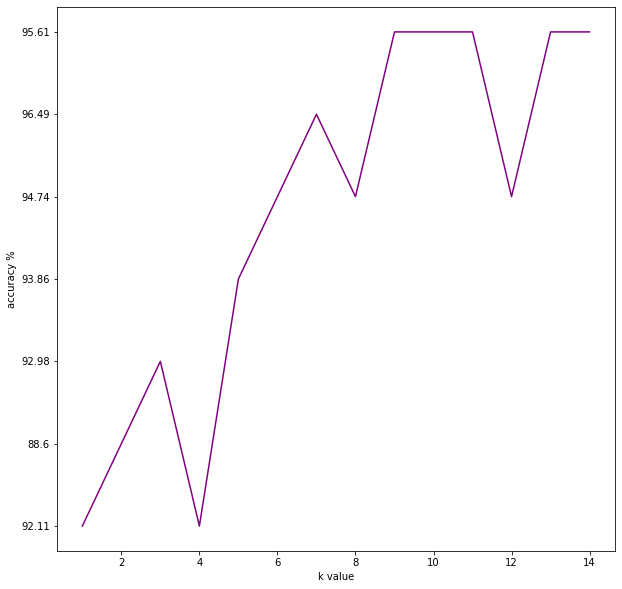

In [14]:
x = [i[0] for i in accuracies]
y = [i[1] for i in accuracies]
plt.figure(figsize=(10,10))
plt.plot(x, y, c='purple')
plt.xlabel('k value')
plt.ylabel('accuracy %')
plt.show()

This graph will have variation if ran multiple times, but accuracy is consistently higher with k >= 5, with 7-10 being the approximately most accurate.

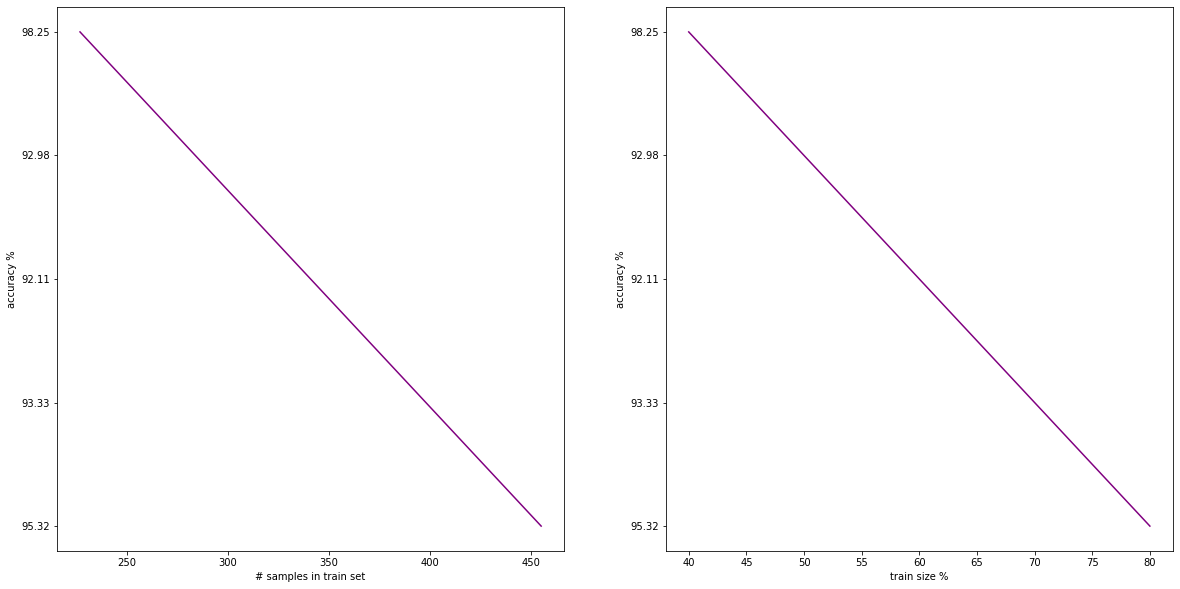

In [47]:
train_acc = list()
train_sizes = [.8, .7, .6, .5, .4]
for i in range(len(train_sizes)):
    train_, test_ = train_test_split(df_cut, test_size=round(1-train_sizes[i], 2), train_size=train_sizes[i])
    acc = evaluate_model_tt(train_, test_, 9, 5)
    train_acc.append([train_.shape[0], acc])
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

x = [i[0] for i in train_acc]
y = [i[1] for i in train_acc]
ax1.plot(x, y, c='purple')
ax1.set_xlabel('# samples in train set')
ax1.set_ylabel('accuracy %')

x = [i*100 for i in train_sizes]
y = [i[1] for i in train_acc]
ax2.plot(x, y, c='purple')
ax2.set_xlabel('train size %')
ax2.set_ylabel('accuracy %')
plt.show()

This graph will have variation if ran multiple times, but accuracy is consistently higher with train size around 60%. This means the above chosen values for train_ and test_ are already good.

## Weighted vs Non Weighted KNN

In [48]:
evaluate_model(df_cut, 9, 5, False)
evaluate_model(df_cut, 9, 5, True)

Average accuracy is 94.21%  with k = 9  ran 5 time(s) and Weighted Distance = False
Average accuracy is 93.51%  with k = 9  ran 5 time(s) and Weighted Distance = True


## Final Predictions

In [50]:
k = 9
train_, validate_, test_ = np.split(df_cut.sample(frac=1), [int(train_size*len(df)), int((round(1-val_test_size, 2))*len(df))])

train_ls = train_.iloc[0:,:].values.tolist()
test_ls = test_.iloc[0:,:].values.tolist()

actual = [row[-1] for row in test_ls]
for row in test_ls:
    row[-1] = None
    
pred = [get_prediction(train_ls, row, k) for row in test_ls]
accuracy = accuracy_metric(actual, pred)
inv_diag_map = {v: k for k, v in diag_map.items()}
test_['diagnosis'] = pred
test_['diagnosis'] = test_['diagnosis'].map(inv_diag_map)

display(test_.head(5))
print("Accuracy: " + str(round(accuracy, 2)) + "%", " with k =", k)

matrix = confusion_matrix(actual, pred)
print("\nConfusion Matrix:\n", matrix)
report = classification_report(actual, pred)
print("\nClassification Report:")
print(report)

,concave points_worst,radius_worst,compactness_worst,perimeter_mean,concavity_mean,compactness_mean,radius_se,diagnosis
349,0.163780,0.173604,0.156407,0.231083,0.027437,0.310472,0.090349,B
345,0.140000,0.104945,0.132249,0.154861,0.083903,0.221489,0.082021,B
152,0.539863,0.109925,0.242464,0.138138,0.962512,0.431017,0.258193,M
506,0.277938,0.186055,0.198126,0.246562,0.191542,0.293908,0.025204,B
193,0.501375,0.274635,0.430102,0.258172,0.254217,0.355561,0.106391,B


Accuracy: 93.54%  with k = 9

Confusion Matrix:
 [[145  26]
 [  3 275]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       171
         1.0       0.91      0.99      0.95       278

    accuracy                           0.94       449
   macro avg       0.95      0.92      0.93       449
weighted avg       0.94      0.94      0.93       449



- The recall means "how many of this class you find over the whole number of element of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

## Overfitting sanity check

In [43]:
df = pd.read_csv("./data/Iris.csv")
normalize(df, 1, ['Species'])
k = 9
train_, validate_, test_ = np.split(df.sample(frac=1), [int(train_size*len(df)), int((round(1-val_test_size, 2))*len(df))])

train_ls = train_.iloc[0:,:].values.tolist()
test_ls = test_.iloc[0:,:].values.tolist()

actual = [row[-1] for row in test_ls]
for row in test_ls:
    row[-1] = None
    
pred = [get_prediction(train_ls, row, k) for row in test_ls]
accuracy = accuracy_metric(actual, pred)

matrix = confusion_matrix(actual, pred)
print("\nConfusion Matrix:\n", matrix)
report = classification_report(actual, pred)
print("\nClassification Report:")
print(report)


Confusion Matrix:
 [[10  0  0]
 [ 0 13  1]
 [ 0  0  6]]

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.93      0.96        14
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.98      0.96        30
   weighted avg       0.97      0.97      0.97        30

